In [1]:
#import any necessary libraries in this block
from __future__ import print_function
from fenics import *
from ufl import nabla_div
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#define global variables

## Test with 2D Advection-diffusion equation

$-\frac{1}{Pe}\Delta u + \mathbf{b} \cdot \nabla u = f \quad \textrm{on} \quad \Omega = (0,1) \times (0,1)$



Text(0.5, 1.0, 'Exact solution')

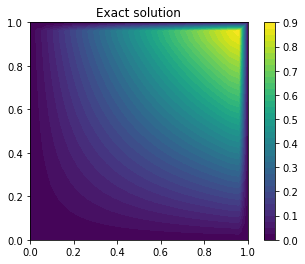

In [2]:
nx=25
mesh=UnitSquareMesh(nx,nx)
b=Constant((1.0,1.0))
Pe = 100

u_D = Expression('(x[0]+ (exp(Pe*b[0]*x[0]) - 1)/(1 - exp(Pe*b[0])) )*( x[1]+ (exp(Pe*b[1]*x[1]) - 1)/(1 - exp(Pe*b[1])))',
                 degree=4, Pe=Pe, b=b,domain=mesh)

p=plot(u_D,mesh=mesh)
plt.colorbar(p)
plt.title('Exact solution')

In [3]:
#weak form
V=FunctionSpace(mesh,'DG',2) #higher degrees seem to go poorly
u=TrialFunction(V)
v=TestFunction(V)
n=FacetNormal(mesh)
bn=(dot(b,n) + abs(dot(b,n)))/2
hmax=mesh.hmax()
tau=hmax/(dot(b,b)**0.5)

uu = interpolate(u_D,V)
f=-1/Pe*div(grad(u_D)) + dot(b,grad(u_D))

F = 1/Pe*inner(grad(u), grad(v)) * dx - inner(b*u,grad(v))*dx - f*v*dx + inner( u*dot(b,n), v )*ds  \
+ inner( bn('+')*u('+') - bn('-')*u('-'), jump(v) )*dS 
#+ inner(-1/Pe*div(grad(u))+dot(b,grad(u)) -f, tau*nabla_div(b*v))*dx

#L = f*v*dx #+ f*tau*nabla_div(b*v)*dx
a,L=lhs(F),rhs(F)
u_sol = Function(V)

def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary,"geometric")

solve(a == L, u_sol, bc)

L2 Error:
0.0169453649618


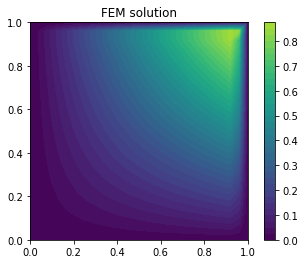

In [4]:
p=plot(u_sol,vmin=0, vmax=1)
plt.colorbar(p)
plt.title('FEM solution')

l2_err = np.sqrt(assemble(inner(u_sol-uu,u_sol-uu)*dx))
print('L2 Error:')
print(l2_err)


In [ ]:
#now test case 1 barebones this time
nx = 20
num_steps = 400
T = num_steps*5/1000 # final time step
T_i=0

dt = T / num_steps
L = 10
mesh = RectangleMesh(Point(0.0,0.0),Point(L,L),nx, nx)
V=FunctionSpace(mesh,'DG',1)
c = Constant((1.0,1.0))
u_D = Expression('sin((x[0]-c[0]*t))+cos((x[1]-c[1]*t))',degree=4, c=c, t=T_i,domain=mesh)
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary,"geometric")
#define initial condition for weak form
u_n = interpolate(u_D, V)

#define variables for stabilized weak form
n=FacetNormal(mesh)
cn=(dot(c,n) + abs(dot(c,n)))/2
hmax=mesh.hmax()
tau=hmax/(dot(c,c)**0.5)

u = TrialFunction(V)
v = TestFunction(V)

F = inner(u - u_n,v)*dx - dt*inner(c*u,grad(v))*dx  \
    + dt*inner( cn('+')*u('+') - cn('-')*u('-'), jump(v) )*dS + dt*inner( u*dot(c,n), v )*ds \
    + dt*inner((u- u_n) + dt*nabla_div(c*u) , tau*nabla_div(c*v))*dx 

a,L = lhs(F), rhs(F)

# establishes solution variable (possible output)
u_sol = Function(V)

t=0

l2_err_vec=np.zeros(num_steps)
l_inf_error_vec = np.zeros(num_steps)

#now loop through time

for n in range(num_steps):
    #advance time
    t+=dt
    #update dirichlet boundary and source term
    u_D.t = t
        
    #compute solution at new timestep
    solve(a == L, u_sol, bc)
    #update solution
    u_n.assign(u_sol)
    
    # Compute exact solution at vertices(assumes u_D is expression for whole space)
    u_e = interpolate(u_D, V)
    #L2 error
    e0=u_sol-u_e
    l2_err_vec[n] = np.sqrt(assemble(inner(e0,e0)*dx))
    #l infinity error
    u_vec=u_sol.compute_vertex_values()
    u_exac_vec=u_e.compute_vertex_values()
    #L infinity error
    l_inf_error_vec[n] = np.abs(u_exac_vec-u_vec).max()

In [ ]:
p=plot(u_sol)
plt.colorbar(p)

In [ ]:
plt.plot(l2_err_vec)

## Reduce case to 1D scalar advection equation to see if we can reproduce problem:

$u_t + a u_x = 0$

discretize time leads to:

$u^{i+1} + dt*a u^i_x - dt*u^i$

...

## First do 1-D scalar advection diffusion problem

$-\epsilon u_{xx} + u_x = 0 \quad \textrm{on} \quad \Omega = (0,1)$

$u(0) = 0, u(1)=1$

which admits the following solution:

$u = \frac{1-e^{\frac{1}{\epsilon}x}}{1 - e^{\frac{1}{\epsilon}}}$

want to see oscillations for small epsilon


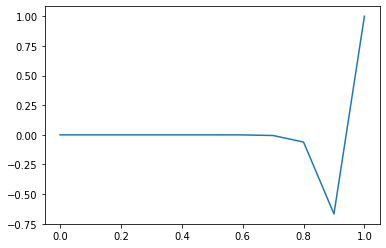

In [87]:
epsilon = 1/100
nx = 10
mesh = UnitIntervalMesh(nx)
ptype = 'DG'
V = FunctionSpace(mesh, ptype, 1)
u = TrialFunction(V)
v = TestFunction(V)

#exact solution
u_exact = Expression('(1 - exp(x[0]/e1))/(1 - exp(1/e1))',degree=6,e1=epsilon,domain=mesh)


def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_exact, boundary)


#weak form

#continuous galerkin
#F = epsilon*u.dx(0)*v.dx(0)*dx + u.dx(0)*v*dx

#SUPG
#hmax=mesh.hmax()
#c=1 #advection speed
#tau=hmax/c
#F = epsilon*u.dx(0)*v.dx(0)*dx - u*v.dx(0)*dx + inner(-epsilon*u.dx(0).dx(0) + u.dx(0), tau*v.dx(0) )*dx

#DG
n=FacetNormal(mesh)
c=as_vector((Constant(1.0),))
cn=(dot(c,n) + abs(dot(c,n)))/2
#x = SpatialCoordinate(mesh)
#Gamma_in = conditional(x < 1e-14,1,0 )
#Gamma_out = conditional(x < 1e-14,1,0)
F = epsilon*u.dx(0)*v.dx(0)*dx - u*v.dx(0)*dx + inner( cn('+')*u('+') - cn('-')*u('-'), jump(v) )*dS \
+ cn*(u-u_exact)*v*ds - epsilon*jump(v)*avg(u.dx(0))*dS

#SUPGDG
#hmax=mesh.hmax()
#c=1 #advection speed
#tau=hmax/c
#c=as_vector((Constant(1.0),))
#cn=(dot(c,n) + abs(dot(c,n)))/2
#F = epsilon*u.dx(0)*v.dx(0)*dx - u*v.dx(0)*dx + inner(-epsilon*u.dx(0).dx(0) + u.dx(0), tau*v.dx(0) )*dx \
#+ inner( cn('+')*u('+') - cn('-')*u('-'), jump(v) )*dS + cn*(u-u_exact)*v*ds - epsilon*jump(v)*avg(u.dx(0))*dS

a,L = lhs(F),rhs(F)

u_sol = Function(V)
if ptype == 'DG':
    
    solve(a == L, u_sol)
else:
    solve(a == L, u_sol,bc)

plot(u_sol)


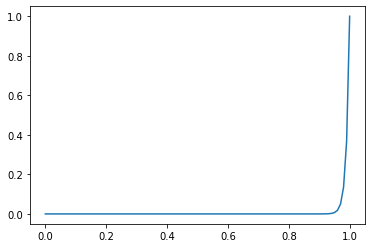

In [81]:
plot(u_exact,mesh=mesh)